# Overview

This notebook demonstrates how to parse “Race Lap Analysis” PDF. We try two approaches:

1. table transformer (Smock et al., CVPR [2022](https://arxiv.org/pdf/2110.00061.pdf))
1. off-the-shelf PyMuPDF
1. manually get the bounding boxes of the tables and extract the text

## Table transformer

Code is mostly from [NielsRogge/Transformers-Tutorials](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR).

## PyMuPDF

In [93]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
rc = {'figure.figsize': (4, 3),
      'axes.facecolor': 'white',             # Remove background colour
      'axes.grid' : False,                   # Turn on grid
      'axes.linewidth': '0.2',
      'axes.edgecolor': '0',                 # Set axes edge color to be black
      'font.size': 2,
      'xtick.major.size': 1,
      'xtick.major.width': 0.2,
      'ytick.major.size': 1,
      'ytick.major.width': 0.2}
plt.rcdefaults()
plt.rcParams.update(rc)

def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 400
    
    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))


In [94]:
import fitz

doc = fitz.open("../1.pdf")
page = doc[0]

Table 0 column names: ['FORMULA 1 ETIHAD AIRWAYS ABU DHABI GRAND PRIX 2023 - Yas Island', None, None, None, None, None], external: False
Table 1 column names: ['LAP', '', 'TIME'], external: True
Table 2 column names: ['LAP', '', 'TIME'], external: True
Table 3 column names: ['LAP', '', 'TIME'], external: True
Table 4 column names: ['LAP', '', 'TIME'], external: True


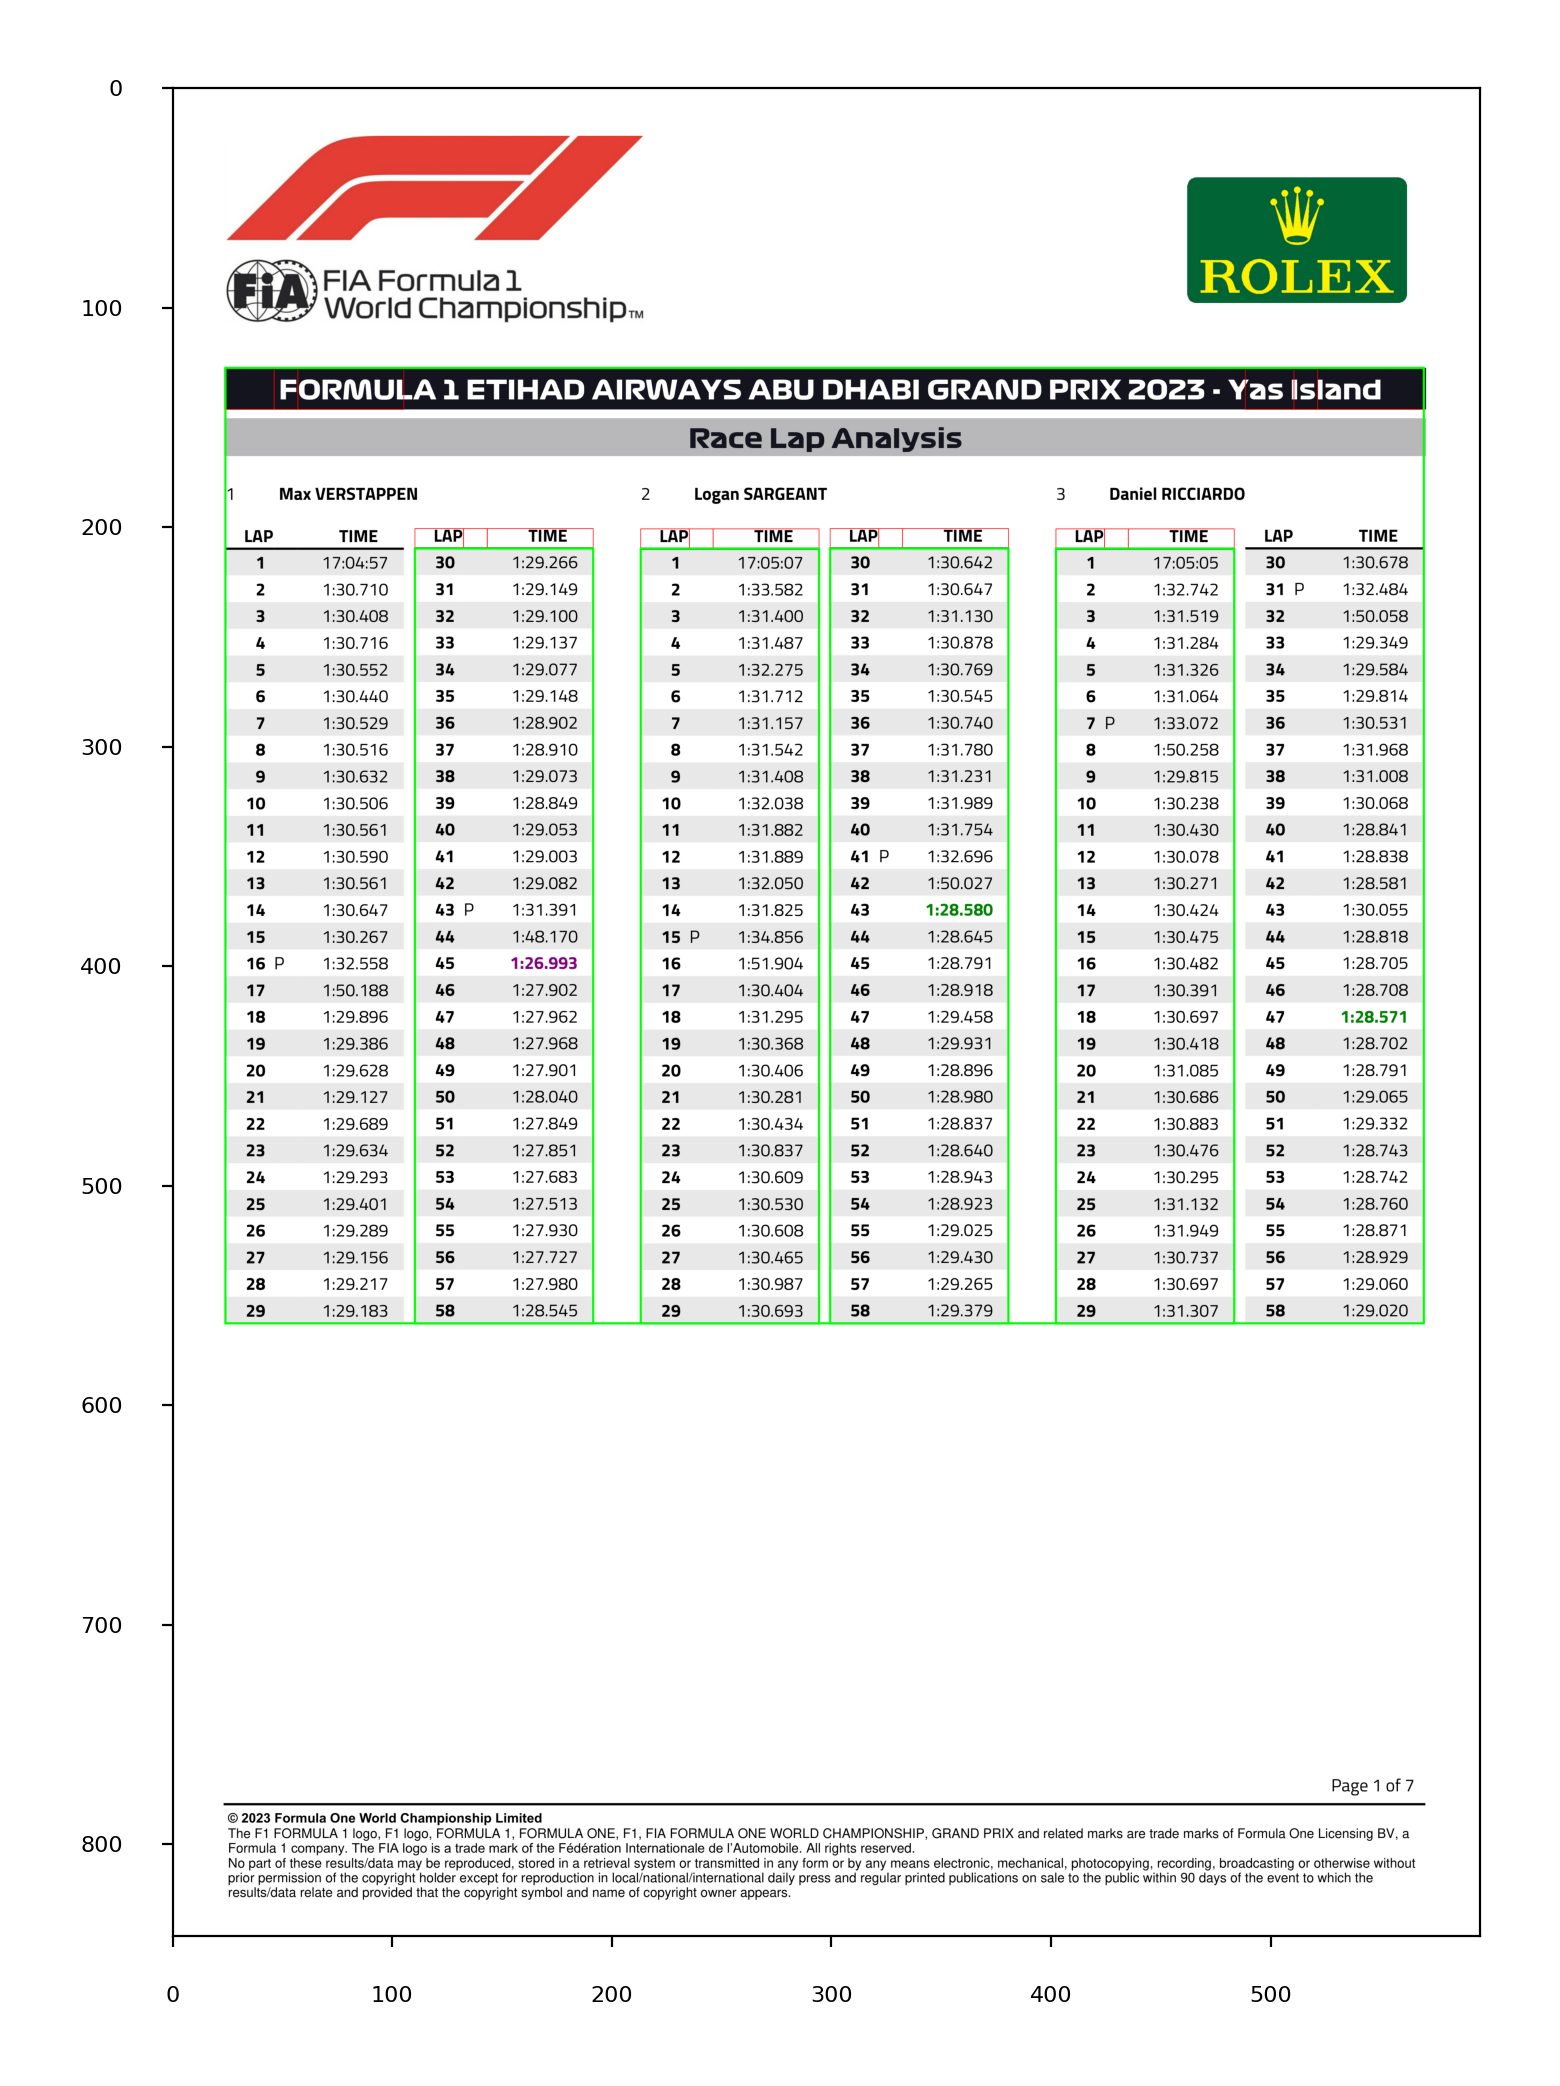

In [95]:
tabs = page.find_tables(strategy='lines')  # detect the tables
for i,tab in enumerate(tabs):  # iterate over all tables
    for cell in tab.header.cells:
        page.draw_rect(cell,color=fitz.pdfcolor["red"], width=0.3)
    page.draw_rect(tab.bbox,color=fitz.pdfcolor["green"])
    print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")
    
show_image(page)

In [4]:
tabs[1].to_pandas()

,LAP,Col1,TIME
0,30,,1:29.266
1,31,,1:29.149
2,32,,1:29.100
3,33,,1:29.137
4,34,,1:29.077
5,35,,1:29.148
6,36,,1:28.902
7,37,,1:28.910
8,38,,1:29.073
9,39,,1:28.849


Very impressive. But why we lost the very left and right table? Page margin?

In [100]:
page.bound()

Rect(0.0, 0.0, 595.4400024414062, 841.6799926757812)

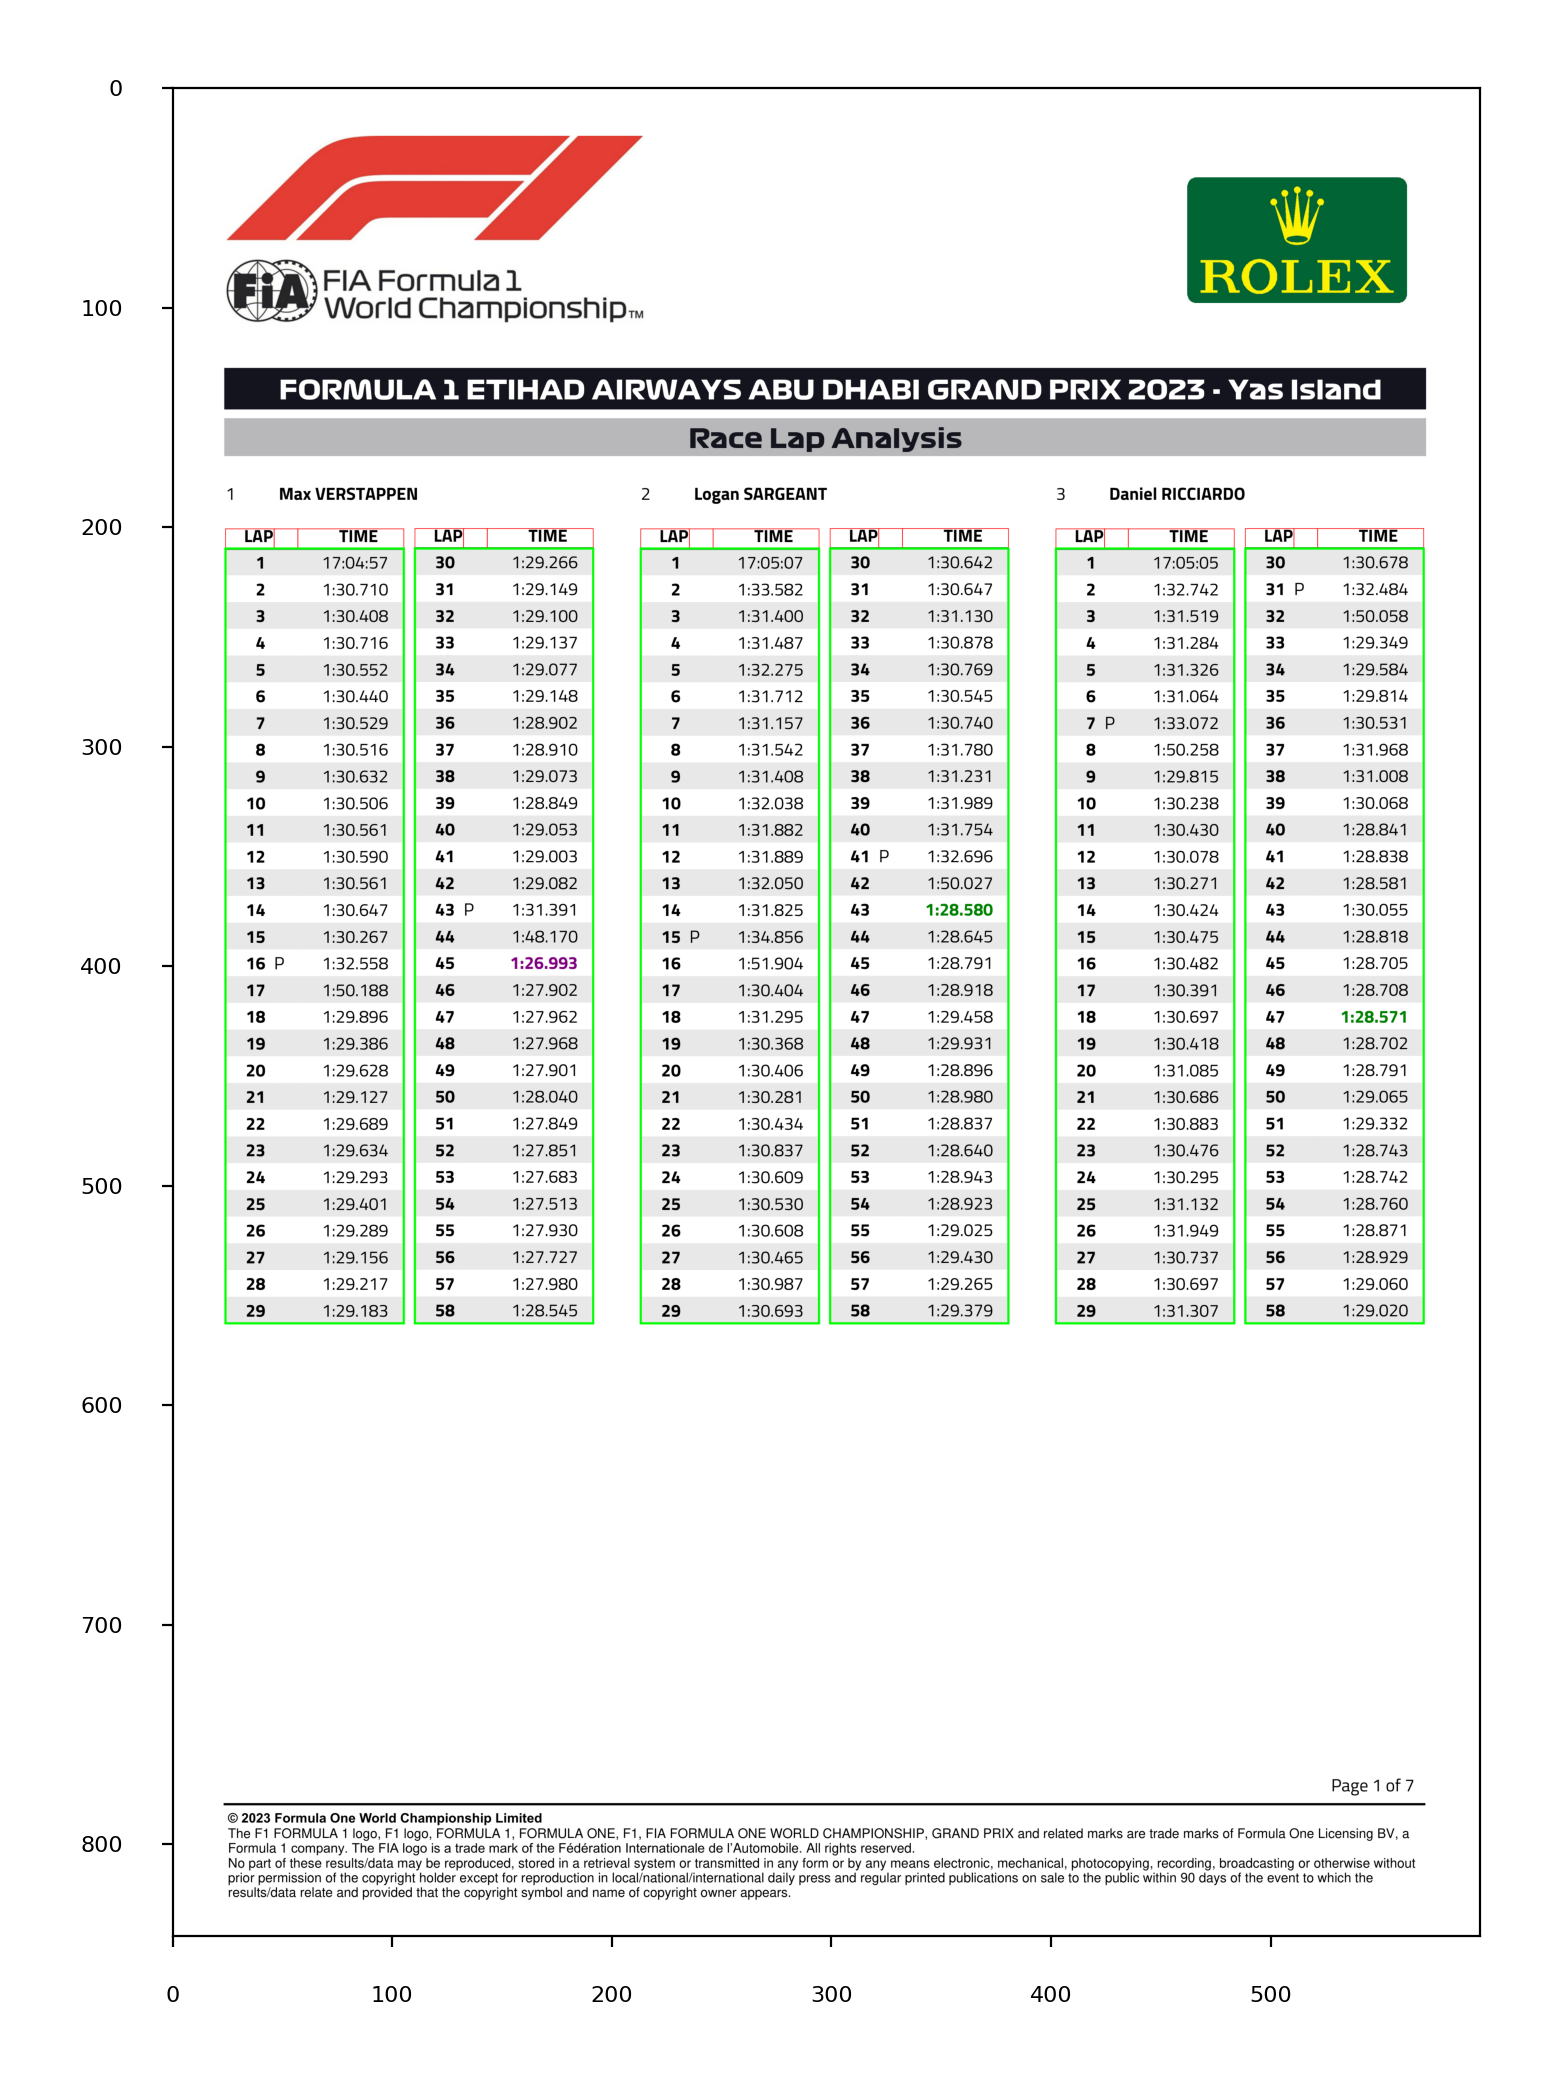

In [103]:
doc = fitz.open("../1.pdf")
page = doc[0]
tabs = page.find_tables(clip=fitz.Rect(5, 190, 590, 600), strategy='lines')

for i,tab in enumerate(tabs):
    for cell in tab.header.cells:
        page.draw_rect(cell,color=fitz.pdfcolor["red"], width=0.3)
    page.draw_rect(tab.bbox,color=fitz.pdfcolor["green"])
    # print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")
    
show_image(page)

In [97]:
tabs[0].to_pandas()

,LAP,Col1,TIME
0,1,,17:04:57
1,2,,1:30.710
2,3,,1:30.408
3,4,,1:30.716
4,5,,1:30.552
5,6,,1:30.440
6,7,,1:30.529
7,8,,1:30.516
8,9,,1:30.632
9,10,,1:30.506
